In [11]:
import numpy as np
from keras.layers import Layer, Concatenate, Input, Dense
import keras.backend as K
from keras.models import load_model, Model
from keras.metrics import CategoricalAccuracy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [12]:
model_dir = 'model'
tanh_layer_size = 300
input_size = 1280
output_size = 2327
regions = 15

In [13]:
class QGAttention(Layer):
    def __init__(self, tanh_layer_size):
        super(QGAttention, self).__init__()
        self.tanh_layer_size = tanh_layer_size
 
    def build(self,input_shape):
        self.W1 = self.add_weight(name='attention_weight', shape=(input_shape[2], self.tanh_layer_size), 
                               initializer='random_normal', trainable=True)
        self.W2 = self.add_weight(name='attention_weight2', shape=(self.tanh_layer_size, 1), 
                               initializer='random_normal', trainable=True)
        #self.b=self.add_weight(name='attention_bias', shape=(1, 32), 
        #                       initializer='zeros', trainable=True)        
        super(QGAttention, self).build(input_shape)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "tanh_layer_size": self.tanh_layer_size,
        })
        return config
    
    # x = [batch_size, vector_length, regions]
    def call(self,x):
        #tanh layer
        e = K.relu(K.dot(x, self.W1))
        #linear layer
        #print('e: ', e)
        e = K.dot(e, self.W2)
        #print('e: ', e)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        #print('e: ', e)
        # Compute the weights
        alpha = K.softmax(e)
        #print('alpha: ', alpha)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        #print('alpha: ', alpha)
        # Compute the context vector
        context = x * alpha
        #print('context: ', context)
        context = K.sum(context, axis=1)
        #print('context: ', context)
        return context

In [46]:
def get_model(regions, vector_input_size, tanh_layer_size):
    inputs = Input(shape=(regions, vector_input_size))
    inputs2 = QGAttention(tanh_layer_size)(inputs)
    inputs3 = Dense(5000, activation='sigmoid')(inputs2)
    outputs = Dense(output_size, activation='sigmoid')(inputs3)
    model = Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.00001,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule), 
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    return model

In [47]:
def train(x, y):
    model = get_model(regions, input_size, tanh_layer_size)
    print(model.summary())
    
    es = EarlyStopping(monitor='val_categorical_accuracy', 
                       mode='max', 
#                        min_delta=0.5, 
                       patience=20)
    mc = ModelCheckpoint('model/best_model.h5', 
                         monitor='val_categorical_accuracy', 
                         mode='max', 
                         save_best_only=True,
                         save_weights_only=True)
    
    history = model.fit(x, y, 
                        verbose=2, 
                        validation_split=0.1, 
                        epochs=1000, 
                        callbacks=[es, mc],
#                         batch_size=70
                       )
    
    model.load_weights('model/best_model.h5')
    
    _, old_acc = evaluate(x, y)
    _, new_acc = model.evaluate(x, y)
    if new_acc > old_acc:
        model.save(model_dir)
    return history

In [48]:
def predict(x):
    model = load_model(model_dir)
    print(model.predict(x))

In [49]:
def evaluate(x, y):
    model = load_model(model_dir)
    return model.evaluate(x, y)

In [50]:
def concat(question_str, regions_str):
    question = str2fv(question_str)
    regs = str2fvs(regions_str)
    result = []
    regs_count = len(regs)
    for i in range(0, regions):
        if i >= regs_count-1:
            result.append([0]*1280)
            continue
        reg = regs[i]
        reg.extend(question)
        result.append(reg)
    return result
    
def str2fvs(string):
    fvs = []
    for strfv in string.split('#'):
        fv = []
        for v in strfv.split('|'):
            fv.append(float(v))
        fvs.append(fv)
    return fvs

def str2fv(string):
    fv = []
    for v in string.split('|'):
        fv.append(float(v))
    return fv

In [51]:
df = pd.read_csv('data/train.csv')
df.head()

,question,id,img_regions,answer_type,0.1,00 310 539,1,1 08 11,1 3,1 4 ounce,...,yes green grey,yes grey shirt,yes no,yes on,yes white,yes yes,yogurt,yoplait,yorkie,zipper
0,-0.2378118336200714|0.343080997467041|-0.21145...,1616,0.4848161041736603|0.8302670121192932|0.333211...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.06691977381706238|0.34440624713897705|-0.22...,11910,0.5611845254898071|0.39622652530670166|0.21795...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.11341997981071472|0.2821967899799347|-0.144...,13392,0.9789563417434692|0.17534661293029785|0.13067...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.10996074229478836|0.4101363718509674|-0.159...,7274,1.396734595298767|0.0643806904554367|0.0101861...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.10682886093854904|0.34835386276245117|-0.120...,15488,0.34761351346969604|1.1078996658325195|0.77606...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
x = []
y = []
for row in df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    x.append(concat(question, img_regions))
    y.append(answer)

X = tf.convert_to_tensor(x)
Y = tf.convert_to_tensor(y)

In [53]:
history = train(X, Y)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 1280)]        0         
                                                                 
 qg_attention_3 (QGAttention  (None, 1280)             384300    
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 5000)              6405000   
                                                                 
 dense_5 (Dense)             (None, 2327)              11637327  
                                                                 
Total params: 18,426,627
Trainable params: 18,426,627
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
158/158 - 9s - loss: 10.8990 - categorical_accuracy: 0.0493 - val_loss: 10.0254 - val_categoric

Epoch 49/1000
158/158 - 8s - loss: 9.3148 - categorical_accuracy: 0.1312 - val_loss: 13.9549 - val_categorical_accuracy: 0.1139 - 8s/epoch - 53ms/step
Epoch 50/1000
158/158 - 8s - loss: 9.3093 - categorical_accuracy: 0.1310 - val_loss: 14.0245 - val_categorical_accuracy: 0.1085 - 8s/epoch - 53ms/step
Epoch 51/1000
158/158 - 8s - loss: 9.3299 - categorical_accuracy: 0.1267 - val_loss: 14.0876 - val_categorical_accuracy: 0.1139 - 8s/epoch - 53ms/step
Epoch 52/1000
158/158 - 8s - loss: 9.3198 - categorical_accuracy: 0.1275 - val_loss: 14.1649 - val_categorical_accuracy: 0.1085 - 8s/epoch - 53ms/step
Epoch 53/1000
158/158 - 8s - loss: 9.3390 - categorical_accuracy: 0.1265 - val_loss: 14.2355 - val_categorical_accuracy: 0.1121 - 8s/epoch - 53ms/step
176/176 [==============================] - 2s 9ms/step - loss: 9.4761 - categorical_accuracy: 0.1309


### ovo prvo srediti - izgleda da je mreza previse jednostavna

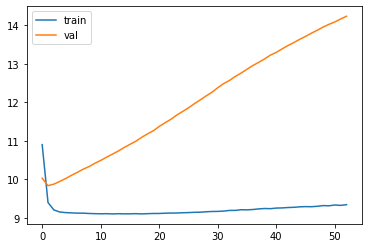

In [54]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

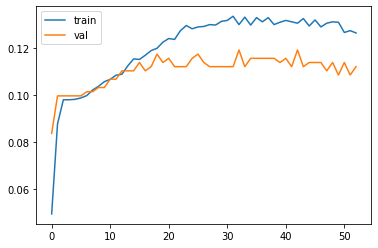

In [55]:
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [56]:
_, acc = evaluate(X, Y)
acc

176/176 [==============================] - 1s 5ms/step - loss: 8.4583 - categorical_accuracy: 0.2485


0.24848592281341553

In [57]:
test_df = pd.read_csv('data/test.csv')

## NUMBERS

In [58]:
number_df = test_df[test_df.answer_type == 'number']
print(number_df.shape[0])

tx = []
ty = []
for row in number_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

5
1/1 [==============================] - 0s 63ms/step - loss: 6.1905 - categorical_accuracy: 0.2000


[6.190515995025635, 0.20000000298023224]

## YES/NO

In [59]:
yesno_df = test_df[test_df.answer_type == 'yes/no']
print(yesno_df.shape[0])

tx = []
ty = []
for row in yesno_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

49
2/2 [==============================] - 0s 5ms/step - loss: 6.4827 - categorical_accuracy: 0.2449


[6.482658386230469, 0.2448979616165161]

## OTHER

In [60]:
other_df = test_df[test_df.answer_type == 'other']
print(other_df.shape[0])

tx = []
ty = []
for row in other_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

568
18/18 [==============================] - 0s 5ms/step - loss: 8.9767 - categorical_accuracy: 0.1127


[8.976716995239258, 0.11267605423927307]

## TOTAL

In [61]:
tx = []
ty = []
for row in test_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

20/20 [==============================] - 0s 5ms/step - loss: 8.7532 - categorical_accuracy: 0.1234


[8.75318431854248, 0.12339743226766586]